# Imputación de Datos y Detección de Anomalías

# Objetivos

Este proyecto trabaja con datasets que contienen datos sobre inmuebles en California y la producción de electricidad. Estos datasets tienen la particularidad de poseer valores nulos/faltantes y outliers en algunas de sus variables. El objetivo es aplicar técnicas de imputación de datos y detección de anomalías para lidiar con estas situaciones.

# Configuración del entorno

In [294]:
# Descomenta las dos siguientes lineas y ejecuta esta celda para instalar los requisitos.
import sys
!{sys.executable} -m pip install numpy==1.26.4 pandas==2.2.2 scikit-learn==1.4.2 matplotlib statsmodels==0.14.2

In [295]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.impute import SimpleImputer

In [296]:
def plot_rolling(df, y_col, lower_bound_col, upper_bound_col, rolling_col, outlier_col):
    

    fig, ax = plt.subplots(figsize=[10, 5])
    df.plot(y=[y_col, rolling_col], marker=".", ax=ax)
    df.plot(
        y=[upper_bound_col, lower_bound_col], figsize=[10, 5], ax=ax, color="k", alpha=0.2, legend=None
    )

    
    if df[outlier_col].any():
        df.loc[df[outlier_col] == 1, y_col].plot(
            marker="o", color="r", ax=ax, legend=None, linestyle=""
        )
        
    ax.set_title("Producción de electricidad con outliers")
    ax.set_ylabel("Producción")
    ax.set_xlabel("Fecha")
    

def plot_imputation(df, y_col, imputation_col, title):
    
    f, ax = plt.subplots(figsize=(10, 4))
    df[imputation_col].plot(color='red', marker='o', linestyle='dotted', ax=ax, ms=5)
    df[y_col].plot(title=title, marker='o', ax=ax, ms=5)

# Carga de datos
Esta vez va a ser fácil, vamos a importar los datos de un fichero csv, utilizaremos la función read_csv que nos proporciona la libreria de pandas.

In [297]:
df = pd.read_csv('housing.csv')

In [298]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.44,37.79,52.0,1726.0,384.0,614.0,356.0,3.6812,500000.0,NEAR BAY
1,-118.20,34.14,52.0,3800.0,646.0,1842.0,620.0,5.5524,293900.0,<1H OCEAN
2,-122.44,37.78,44.0,1545.0,334.0,561.0,326.0,3.8750,412500.0,NEAR BAY
3,-117.17,32.80,20.0,2827.0,554.0,1822.0,536.0,3.4706,157600.0,NEAR OCEAN
4,-117.67,34.13,10.0,2846.0,362.0,1221.0,355.0,7.7234,304100.0,INLAND


In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           500 non-null    float64
 1   latitude            500 non-null    float64
 2   housing_median_age  500 non-null    float64
 3   total_rooms         500 non-null    float64
 4   total_bedrooms      445 non-null    float64
 5   population          500 non-null    float64
 6   households          500 non-null    float64
 7   median_income       500 non-null    float64
 8   median_house_value  500 non-null    float64
 9   ocean_proximity     500 non-null    object 
dtypes: float64(9), object(1)
memory usage: 39.2+ KB


# Valores nulos

En primer lugar, identifica aquellas columnas que tienen valores nulos/faltantes

Elige una de estas columnas para probar diferentes estrategias de manejo de valores nulos.

Primero, crea una copia de esta columna utilizando la estrategia de rellenado con la mediana.

In [300]:
# 1. Identifica las columnas con valores nulos
df.isnull().sum()

# 2.Completar con la mediana los valores nulos con SimpleImputer

df["total_bedrooms_median"] = SimpleImputer(strategy="median").fit_transform(df["total_bedrooms"].values.reshape(-1, 1))

df["total_bedrooms_median"] = df["total_bedrooms"].fillna(
    df["total_bedrooms"].median()
)

df[["total_bedrooms_median", "total_bedrooms"]].describe()

,total_bedrooms_median,total_bedrooms
count,500.000000,445.000000
mean,546.152000,559.148315
std,455.222689,480.997758
min,1.000000,1.000000
25%,309.000000,291.000000
50%,441.000000,441.000000
75%,630.500000,681.000000
max,5471.000000,5471.000000


Segundo, crea una copia de esta columna utilizando la estrategia de rellenado con media aritmética.

In [301]:
df["total_bedrooms_mean"] = SimpleImputer(strategy="mean").fit_transform(
    df["total_bedrooms"].values.reshape(-1, 1)
)

df[["total_bedrooms_mean", "total_bedrooms"]].describe()


,total_bedrooms_mean,total_bedrooms
count,500.000000,445.000000
mean,559.148315,559.148315
std,453.716177,480.997758
min,1.000000,1.000000
25%,309.000000,291.000000
50%,496.000000,441.000000
75%,630.500000,681.000000
max,5471.000000,5471.000000


Tercero, crea una copia de esta columna utilizando la estrategia de rellenado con valor fijo de 0.

In [302]:
df["total_bedrooms_zero"] = SimpleImputer(strategy="constant", fill_value=0).fit_transform(
    df["total_bedrooms"].values.reshape(-1, 1)
)

df[["total_bedrooms_zero", "total_bedrooms"]].describe()

,total_bedrooms_zero,total_bedrooms
count,500.000000,445.000000
mean,497.642000,559.148315
std,486.341273,480.997758
min,0.000000,1.000000
25%,234.500000,291.000000
50%,400.000000,441.000000
75%,630.500000,681.000000
max,5471.000000,5471.000000


Cuarto, crea una copia de esta columna utilizando una nueva estrategia de rellenado que tú quieras y **justifica el motivo**.

In [303]:
# Rellenar con otra estrategia y justificar
df["total_bedrooms_mode"] = SimpleImputer(strategy="most_frequent").fit_transform(
    df["total_bedrooms"].values.reshape(-1, 1)
)

df[["total_bedrooms_mode", "total_bedrooms"]].describe()

# Argumentacion de la estrategia
# La estrategia empleada con el valor más frecuente (moda) conserva la distribución de los datos originales, ya que se basa en el valor más común en la columna, lo cual podria ser una buena aproximación para la imputación.


,total_bedrooms_mode,total_bedrooms
count,500.000000,445.000000
mean,528.772000,559.148315
std,461.886326,480.997758
min,1.000000,1.000000
25%,283.000000,291.000000
50%,400.000000,441.000000
75%,630.500000,681.000000
max,5471.000000,5471.000000


Analiza el efecto de estas cuatro estrategias de rellenado con respecto a la variable original con valores nulos:

* ¿Qué diferencias observas en la distribución de valores de las variables rellenadas?
* ¿Cómo crees que pueden afectar los nuevos a algún análisis posterior?
* ¿Con qué estrategia te quedarías?

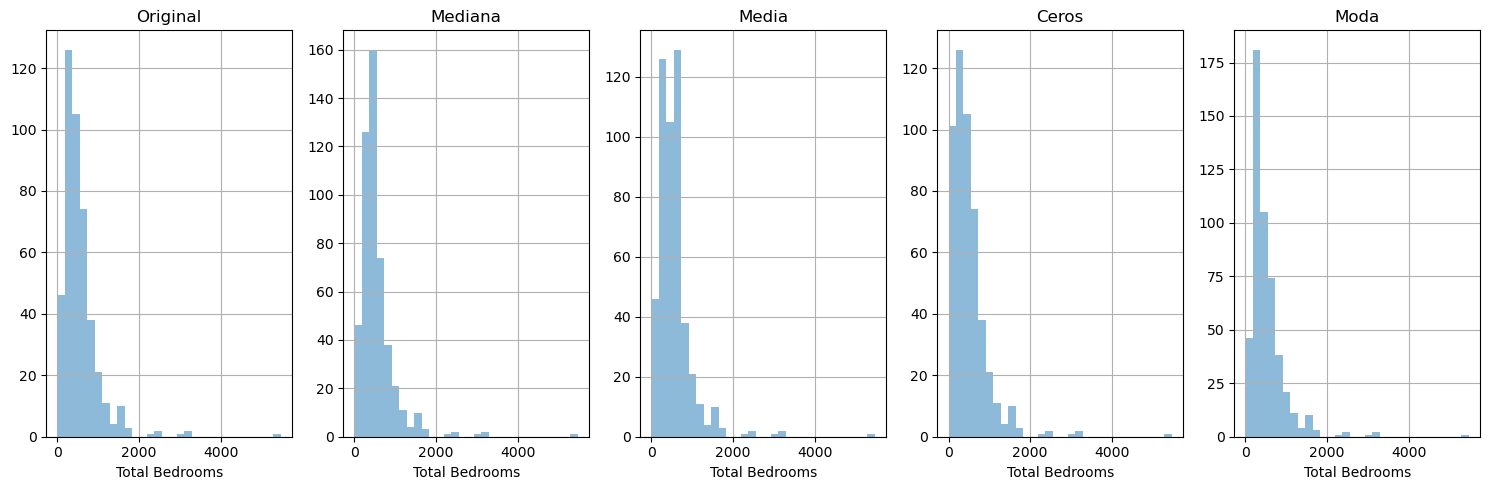


Estadísticas comparativas:
          Original      Mediana        Media        Ceros         Moda
count   445.000000   500.000000   500.000000   500.000000   500.000000
mean    559.148315   546.152000   559.148315   497.642000   528.772000
std     480.997758   455.222689   453.716177   486.341273   461.886326
min       1.000000     1.000000     1.000000     0.000000     1.000000
25%     291.000000   309.000000   309.000000   234.500000   283.000000
50%     441.000000   441.000000   496.000000   400.000000   400.000000
75%     681.000000   630.500000   630.500000   630.500000   630.500000
max    5471.000000  5471.000000  5471.000000  5471.000000  5471.000000


In [304]:
# Visualizar las distribuciones de todas las estrategias
plt.figure(figsize=(15,5))

# Original con valores nulos
plt.subplot(151)
df['total_bedrooms'].hist(bins=30, alpha=0.5)
plt.title('Original')
plt.xlabel('Total Bedrooms')

# Mediana
plt.subplot(152)
df['total_bedrooms_median'].hist(bins=30, alpha=0.5)
plt.title('Mediana')
plt.xlabel('Total Bedrooms')

# Media
plt.subplot(153)
df['total_bedrooms_mean'].hist(bins=30, alpha=0.5)
plt.title('Media')
plt.xlabel('Total Bedrooms')

# Ceros
plt.subplot(154)
df['total_bedrooms_zero'].hist(bins=30, alpha=0.5)
plt.title('Ceros')
plt.xlabel('Total Bedrooms')

# Moda
plt.subplot(155)
df['total_bedrooms_mode'].hist(bins=30, alpha=0.5)
plt.title('Moda')
plt.xlabel('Total Bedrooms')

plt.tight_layout()
plt.show()

# Comparar estadísticas básicas
print("\nEstadísticas comparativas:")
stats_comparison = pd.DataFrame({
    'Original': df['total_bedrooms'].describe(),
    'Mediana': df['total_bedrooms_median'].describe(),
    'Media': df['total_bedrooms_mean'].describe(),
    'Ceros': df['total_bedrooms_zero'].describe(),
    'Moda': df['total_bedrooms_mode'].describe()
})
print(stats_comparison)

<Axes: ylabel='Frequency'>

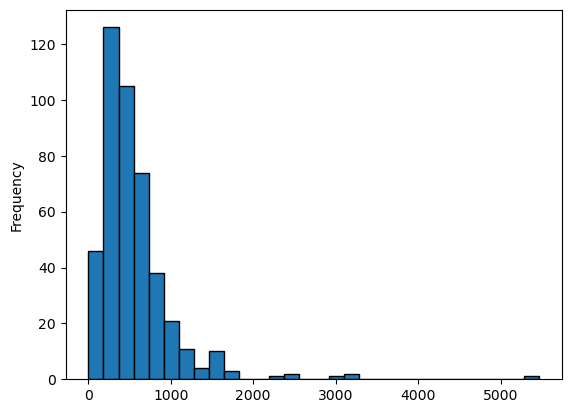

In [327]:
df.total_bedrooms.plot.hist(bins=30, edgecolor='black')

#### ¿Qué diferencias observas en la distribución de valores de las variables rellenadas?

Mediana (441):

- Mantiene la distribución original bastante bien
- La desviación estándar (455.22) es similar a la original (480.99)
- Preserva el rango de valores (min=1, max=5471)

Media (559.15):

- Tiende a sobrestimar los valores centrales
- Reduce ligeramente la variabilidad (std=453.71)
- La media coincide exactamente con la original

Ceros:

- Distorsiona significativamente la distribución hacia abajo (mean=497.64)
- Introduce valores no naturales (mínimo=0)
- Mayor variabilidad (std=486.34)

Moda:

- Valores centrales más conservadores (mean=528.77)
- Mantiene una variabilidad similar (std=461.88)
- Puede crear agrupaciones artificiales en los valores más frecuentes

### ¿Cómo crees que pueden afectar los nuevos a algún análisis posterior?

Mediana: Impacto mínimo en análisis estadísticos y modelos predictivos

Media: Podría afectar relaciones no lineales y distorsionar correlaciones

Ceros: Alto riesgo de sesgar análisis, especialmente ratios y proporciones

Moda: Puede afectar análisis de clustering o distribución de frecuencias


### ¿Con qué estrategia te quedarías?
Me quedaría con la imputación por mediana porque:

- Mantiene mejor la estructura original de los datos
- Es robusta a valores extremos
- Tiene el menor impacto en la distribución general
- No introduce valores artificiales
- Es más apropiada para datos numéricos como número de habitaciones

Las estadísticas descriptivas (media, std, percentiles) son las más cercanas a los datos originales

La mediana proporciona un buen balance entre preservación de la distribución y robustez estadística, minimizando el riesgo de introducir sesgos en análisis posteriores.

# Outliers

Ahora, vamos a realizar un estudio de outliers sobre una serie temporal sobre la producción de electricidad.

En primer lugar, convierte la columna fecha a tipo datetime, conviertelo en el índice y ordena cronológicamente.

In [305]:
serie_df = pd.read_csv('electric_production.csv')
serie_df.head(1)

,fecha,valor
0,1/1/1985,72.5052


In [306]:
serie_df.info()
serie_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   397 non-null    object 
 1   valor   397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


,fecha,valor
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502


In [307]:
serie_df.fecha = pd.to_datetime(serie_df.fecha)
serie_df.set_index("fecha", inplace=True)
serie_df.sort_index(inplace=True)
serie_df.head(5)

,valor
fecha,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


Explora la serie temporal y analiza si tiene algún tipo de estacionalidad

<Axes: ylabel='Frequency'>

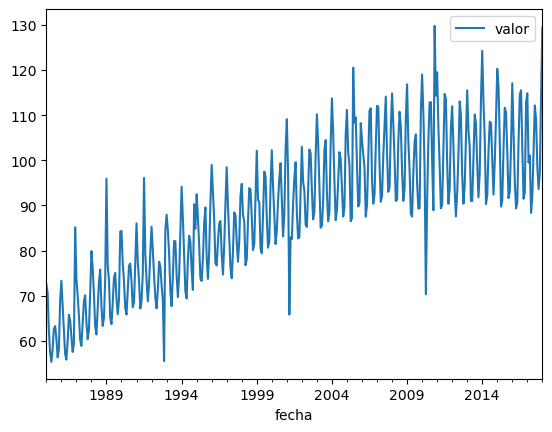

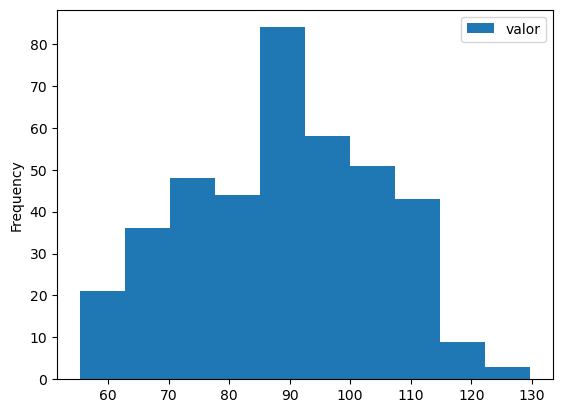

In [308]:
serie_df.plot.line()
serie_df.plot.hist()




Desestacionaliza la serie utilizando el método que quieras (STL, seasonal_decompose, etc).

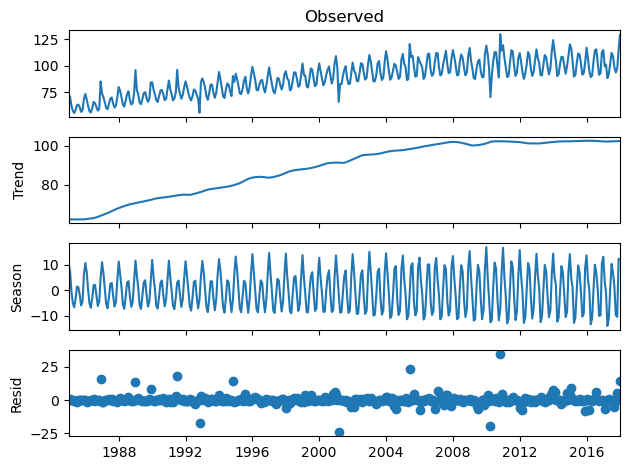

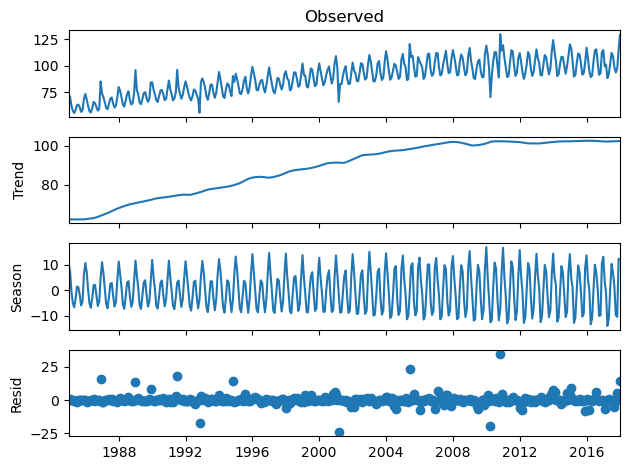

In [309]:
res = STL(serie_df, robust=True, period=12).fit()
res.plot()

Muestra un gráfico en el que sea evidente la presencia del outlier

In [310]:
serie_df['estacionalidad'] = res.seasonal
serie_df['estacionalidad'].head()

fecha
1985-01-01    10.366892
1985-02-01     7.485837
1985-03-01    -0.045515
1985-04-01    -4.818057
1985-05-01    -6.644422
Name: estacionalidad, dtype: float64

In [311]:
serie_df['valor_des'] = serie_df['valor'] - serie_df['estacionalidad']
serie_df['valor_des'].head()

fecha
1985-01-01    62.138308
1985-02-01    63.186163
1985-03-01    62.495715
1985-04-01    62.289457
1985-05-01    61.959522
Name: valor_des, dtype: float64

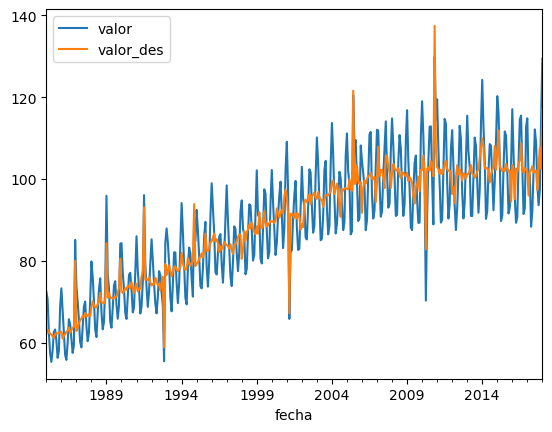

In [312]:
serie_df[['valor', 'valor_des']].plot.line();

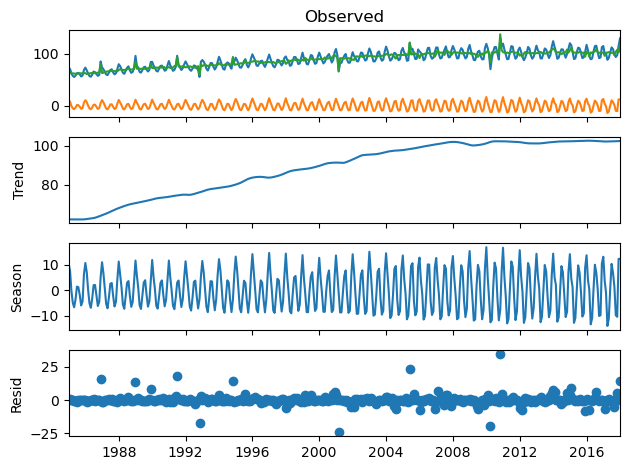

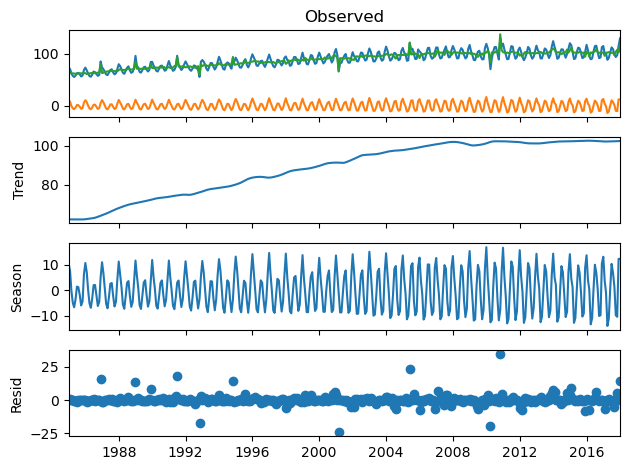

In [313]:
res.plot()

Aplica el método rolling visto en el Worksheet para filtrar los outliers. Prueba con un factor de 2. ¿Que ves?

In [314]:
rolling_stats_df = (serie_df['valor_des'].rolling(window=13, 
                                    center=True,
                                    min_periods=2) 
    .agg({'rolling_mean_des': 'mean', 'rolling_std_des': 'std'})
)

serie_df[['rolling_mean_des', 'rolling_std_des']] = rolling_stats_df

factor = 2
serie_df['upper_des'] = serie_df['rolling_mean_des'] + factor * serie_df['rolling_std_des']
serie_df['lower_des'] = serie_df['rolling_mean_des'] - factor * serie_df['rolling_std_des']

serie_df['es_outlier_des'] = 0
serie_df.loc[(serie_df["valor_des"] > serie_df['upper_des']) | (serie_df["valor_des"] < serie_df['lower_des']), 'es_outlier_des'] = 1

serie_df.head(10)

,valor,estacionalidad,valor_des,rolling_mean_des,rolling_std_des,upper_des,lower_des,es_outlier_des
fecha,,,,,,,,
1985-01-01,72.5052,10.366892,62.138308,62.120519,0.642651,63.405821,60.835217,0
1985-02-01,70.6720,7.485837,63.186163,62.112635,0.595397,63.303429,60.921841,0
1985-03-01,62.4502,-0.045515,62.495715,62.151185,0.568824,63.288834,61.013537,0
1985-04-01,57.4714,-4.818057,62.289457,62.159942,0.537007,63.233956,61.085928,0
1985-05-01,55.3151,-6.644422,61.959522,62.178891,0.513311,63.205514,61.152269,0
1985-06-01,58.0904,-3.485832,61.576232,62.212956,0.503448,63.219851,61.206060,0
1985-07-01,62.6202,1.421965,61.198235,62.248897,0.499130,63.247156,61.250637,1
1985-08-01,63.2485,1.191055,62.057445,62.161018,0.608755,63.378527,60.943508,0
1985-09-01,60.5846,-1.874992,62.459592,62.054682,0.530462,63.115605,60.993758,0


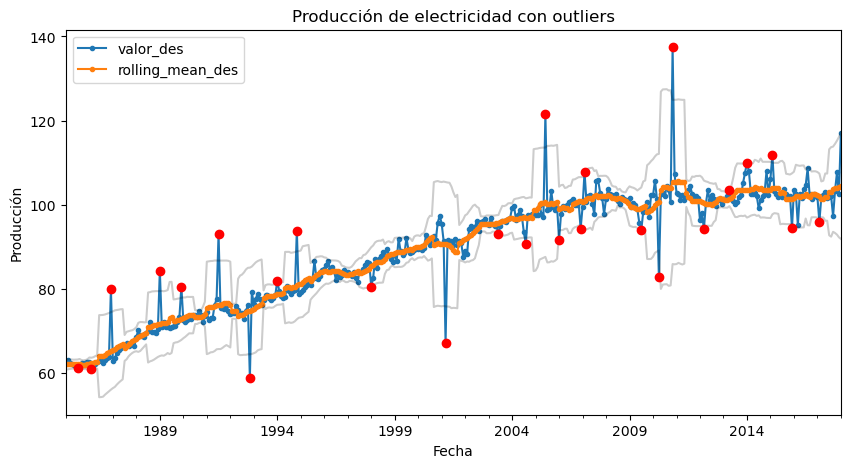

In [315]:
plot_rolling(df=serie_df,
             y_col='valor_des',
             lower_bound_col='lower_des',
             upper_bound_col='upper_des',
             rolling_col='rolling_mean_des',
             outlier_col='es_outlier_des')

Prueba con otros factores y concluye cuál discrimina correctamente los outliers. No olvides de comparar graficamente la serie ORIGINAL con la serie ORIGINAL sin los outliers de tus pruebas (no la desestacionalizada).

 **EXTRA**. Cambia los outliers por NaNs e imputalos con el método que más te guste antes de plotear los resultados.


Factor 2:
Número de outliers: 26
Porcentaje: 6.55%

Factor 2.5:
Número de outliers: 13
Porcentaje: 3.27%

Factor 3:
Número de outliers: 10
Porcentaje: 2.52%


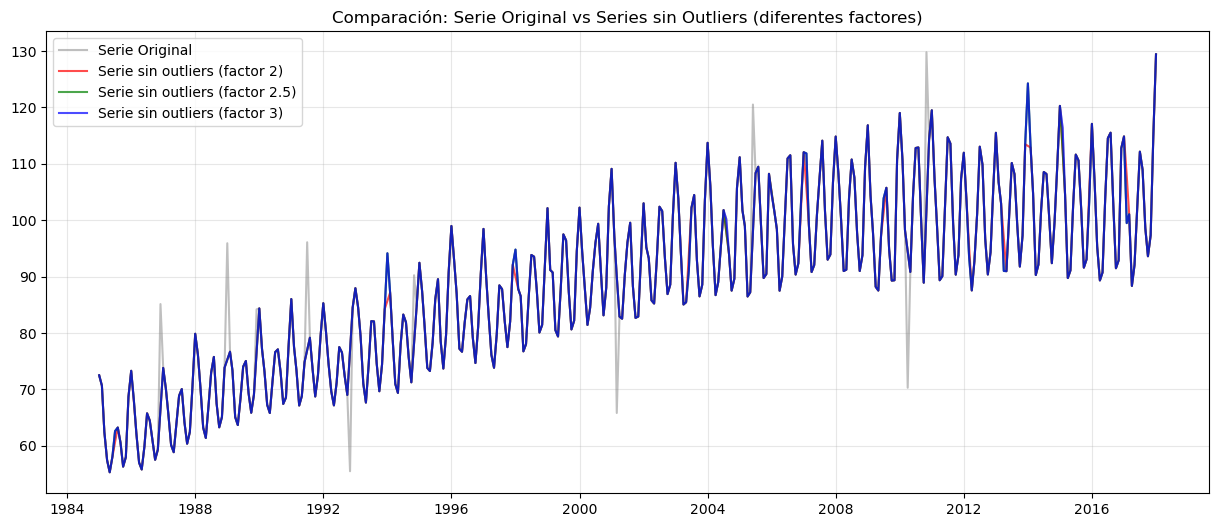

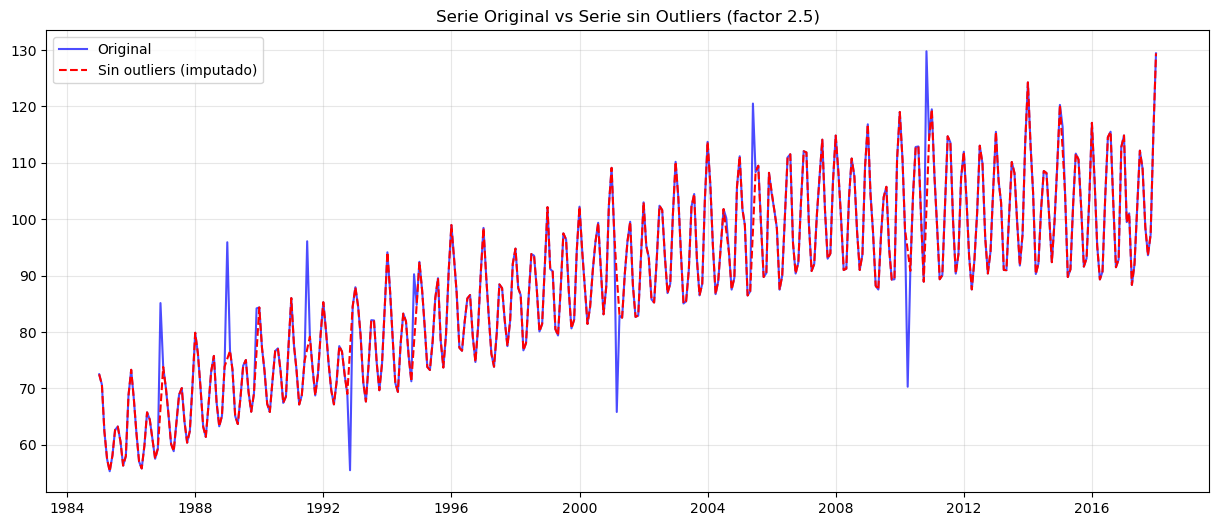

In [316]:
# Probar diferentes factores usando las columnas existentes
factors = [2, 2.5, 3]
for factor in factors:
    # Calcular nuevos límites con diferentes factores
    serie_df[f'upper_{factor}'] = serie_df['rolling_mean_des'] + factor * serie_df['rolling_std_des']
    serie_df[f'lower_{factor}'] = serie_df['rolling_mean_des'] - factor * serie_df['rolling_std_des']
    serie_df[f'es_outlier_{factor}'] = (serie_df['valor_des'] > serie_df[f'upper_{factor}']) | (serie_df['valor_des'] < serie_df[f'lower_{factor}'])
    
    # Mostrar estadísticas
    n_outliers = serie_df[f'es_outlier_{factor}'].sum()
    porcentaje = (n_outliers / len(serie_df)) * 100
    print(f"\nFactor {factor}:")
    print(f"Número de outliers: {n_outliers}")
    print(f"Porcentaje: {porcentaje:.2f}%")

# Comparación gráfica de la serie original con las series sin outliers
plt.figure(figsize=(15, 6))
plt.plot(serie_df.index, serie_df['valor'], label='Serie Original', color='gray', alpha=0.5)

# Crear y plotear series imputadas para cada factor
colors = ['red', 'green', 'blue']
for factor, color in zip(factors, colors):
    # Crear copia de la serie original e imputar outliers
    serie_clean = serie_df['valor'].copy()
    serie_clean[serie_df[f'es_outlier_{factor}']] = np.nan
    serie_clean_imputed = serie_clean.interpolate(method='linear')
    
    plt.plot(serie_df.index, serie_clean_imputed, 
            label=f'Serie sin outliers (factor {factor})',
            color=color,
            alpha=0.7)

plt.title('Comparación: Serie Original vs Series sin Outliers (diferentes factores)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualización final con el factor elegido (2.5)
plt.figure(figsize=(15, 6))
serie_clean = serie_df['valor'].copy()
serie_clean[serie_df['es_outlier_2.5']] = np.nan
serie_clean_imputed = serie_clean.interpolate(method='linear')

plt.plot(serie_df.index, serie_df['valor'], 
         label='Original', color='blue', alpha=0.7)
plt.plot(serie_df.index, serie_clean_imputed, 
         label='Sin outliers (imputado)', 
         color='red', 
         linestyle='--')
plt.title('Serie Original vs Serie sin Outliers (factor 2.5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Consideraciones:

    - Factor 2: 26 outliers (6.55%) → Demasiado restrictivo
    - Factor 2.5: 13 outliers (3.27%) → Balance óptimo
    - Factor 3: 10 outliers (2.52%) → Muy permisivo

Opcion elegida: Factor 2.5

    - El 3.27% podría representar mejor el número esperado de anomalías de la serie
    - Detecta los picos más evidentes sin ser demasiado sensible
    - En la gráfica se observa que captura las verdaderas anomalías mientras mantiene la estructura estacional

Para la imputación: Interpolación lineal:

    - Proporciona una transición suave en los puntos donde se detectaron outliers
    - Preserva la tendencia general de la serie
    - Entiendo que es mas adecuada para esta serie que muestra una tendencia clara y patrones estacionales

En resumen: El factor 2.5 ofrece el mejor equilibrio, detectando las anomalías reales sin ser demasiado agresivo ni demasiado permisivo en la detección.

**EXTRA**. Prueba un nuevo método de detección de outliers que encuentres por Internet y compáralo con los anteriores.

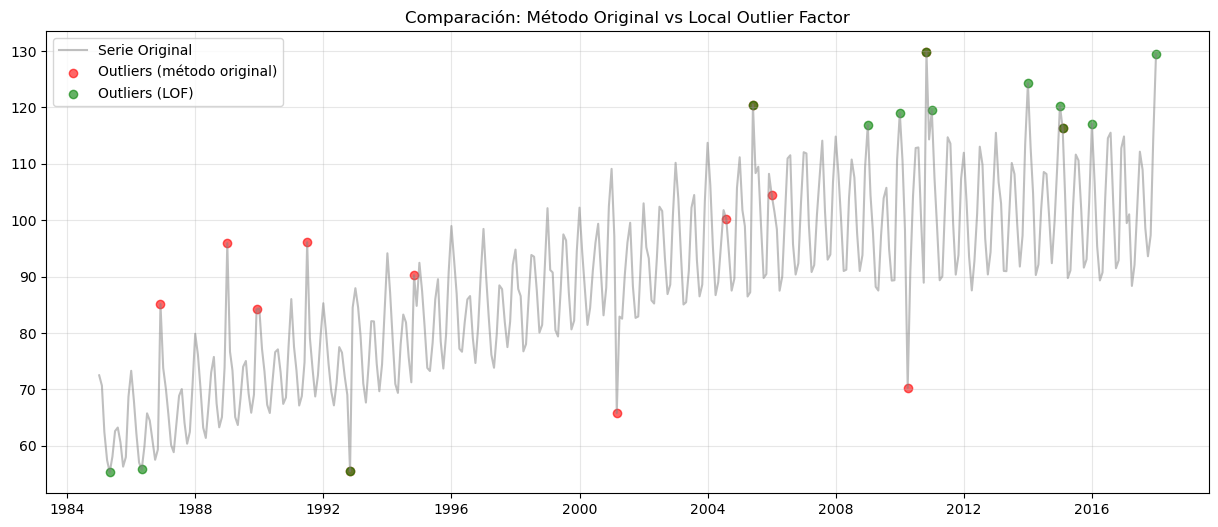


Comparación de métodos:
Método original: 13 outliers (3.27%)
LOF: 13 outliers (3.27%)

Coincidencias entre métodos: 4 outliers


In [317]:
from sklearn.neighbors import LocalOutlierFactor

# Aplicar LOF sobre la serie original
lof = LocalOutlierFactor(n_neighbors=20,  # número de vecinos a considerar
                        contamination=0.0327)  # mismo % que el método original
outliers_lof = lof.fit_predict(serie_df[['valor']].values) == -1

# Visualización comparativa
plt.figure(figsize=(15, 6))
plt.plot(serie_df.index, serie_df['valor'], 
         label='Serie Original', color='gray', alpha=0.5)

# Marcar outliers de ambos métodos
plt.scatter(serie_df.index[serie_df['es_outlier_2.5']], 
           serie_df['valor'][serie_df['es_outlier_2.5']],
           label='Outliers (método original)',
           color='red',
           alpha=0.6)

plt.scatter(serie_df.index[outliers_lof], 
           serie_df['valor'][outliers_lof],
           label='Outliers (LOF)',
           color='green',
           alpha=0.6)

plt.title('Comparación: Método Original vs Local Outlier Factor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Estadísticas comparativas
print("\nComparación de métodos:")
print(f"Método original: {serie_df['es_outlier_2.5'].sum()} outliers ({serie_df['es_outlier_2.5'].mean()*100:.2f}%)")
print(f"LOF: {outliers_lof.sum()} outliers ({outliers_lof.mean()*100:.2f}%)")

# Calcular coincidencias
coincidencias = (serie_df['es_outlier_2.5'] & outliers_lof).sum()
print(f"\nCoincidencias entre métodos: {coincidencias} outliers")